# Week 4: Multi-class Classification

Welcome to this assignment! In this exercise, you will get a chance to work on a multi-class classification problem. You will be using the [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset, which contains 28x28 images of hands depicting the 26 letters of the english alphabet. 

You will need to pre-process the data so that it can be fed into your convolutional neural network to correctly classify each image as the letter it represents.


Let's get started!

In [ ]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

Download the training and test sets (the test set will actually be used as a validation set):

In [ ]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 222MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 244MB/s]


Define some globals with the path to both files you just downloaded:

In [ ]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

Unlike previous assignments, you will not have the actual images provided, instead you will have the data serialized as `csv` files.

Take a look at how the data looks like within the `csv` file:

In [ ]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

 ## Parsing the dataset
 
 

In [ ]:
# GRADED FUNCTION: parse_data_from_input
def parse_data_from_input(filename):
  """
  Parses the images and labels from a CSV file
  
  Args:
    filename (string): path to the CSV file
    
  Returns:
    images, labels: tuple of numpy arrays containing the images and labels
  """
  with open(filename) as file:
    ### START CODE HERE

    # Use csv.reader, passing in the appropriate delimiter
    # Remember that csv.reader can be iterated and returns one line in each iteration
    csv_reader = csv.reader(file, delimiter=',')
    
    rows = np.array([row for row in csv_reader])
    labels = rows[1:, 0]
    images = rows[1:, 1:]

    labels = labels.astype(float)
    images = images.reshape(images.shape[0], 28, 28).astype(float)
    
    ### END CODE HERE

    return images, labels

In [ ]:
# Test your function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


## Visualizing the numpy arrays


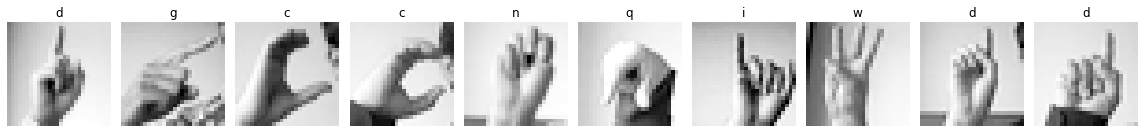

In [ ]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

## Creating the generators for the CNN



In [ ]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  """
  Creates the training and validation data generators
  
  Args:
    training_images (array): parsed images from the train CSV file
    training_labels (array): parsed labels from the train CSV file
    validation_images (array): parsed images from the test CSV file
    validation_labels (array): parsed labels from the test CSV file
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # In this section you will have to add another dimension to the data
  # So, for example, if your array is (10000, 28, 28)
  # You will need to make it (10000, 28, 28, 1)
  # Hint: np.expand_dims
  training_images = np.expand_dims(training_images, axis=3)
  validation_images = np.expand_dims(validation_images, axis=3)


  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values 
  # and set arguments to augment the images (if desired)
  train_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32) 

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow method
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32) 

  ### END CODE HERE

  return train_generator, validation_generator

In [ ]:
# Test your generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


## Coding the CNN


In [ ]:
def create_model():

  ### START CODE HERE       

  # Define the model
  # Use no more than 2 Conv2D and 2 MaxPooling2D
  model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.6),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(25, activation='softmax')
  ])
  

  model.compile(optimizer = RMSprop(learning_rate=1e-4),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  ### END CODE HERE       
  
  return model

In [ ]:
# Save your model
model = create_model()

# Train your model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 [==============================] - 14s 15ms/step - loss: 1.7669 - accuracy: 0.5054 - val_loss: 0.9271 - val_accuracy: 0.7142
Epoch 2/15
858/858 [==============================] - 13s 15ms/step - loss: 0.4908 - accuracy: 0.8522 - val_loss: 0.5255 - val_accuracy: 0.8406
Epoch 3/15
858/858 [==============================] - 13s 15ms/step - loss: 0.2135 - accuracy: 0.9388 - val_loss: 0.3471 - val_accuracy: 0.8862
Epoch 4/15
858/858 [==============================] - 13s 15ms/step - loss: 0.1016 - accuracy: 0.9727 - val_loss: 0.2844 - val_accuracy: 0.9095
Epoch 5/15
858/858 [==============================] - 13s 15ms/step - loss: 0.0561 - accuracy: 0.9852 - val_loss: 0.2363 - val_accuracy: 0.9310
Epoch 6/15
858/858 [==============================] - 13s 15ms/step - loss: 0.0329 - accuracy: 0.9918 - val_loss: 0.2445 - val_accuracy: 0.9308
Epoch 7/15
858/858 [==============================] - 13s 15ms/step - loss: 0.0212 - accuracy: 0.9949 - val_loss: 0.2413 - val_accuracy:

Now take a look at your training history:

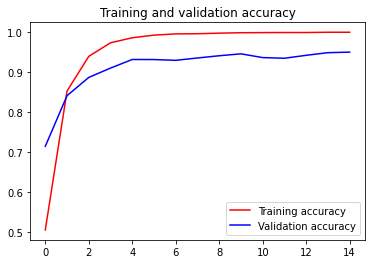

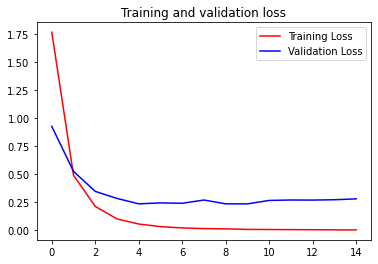

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()